nodes:  50 links  69
Generation 0: Min Fitness 424651.12263778766
Generation 1: Min Fitness 424651.12263778766
Generation 2: Min Fitness 405632.9507607474
Generation 3: Min Fitness 404574.6157891191
Generation 4: Min Fitness 410713.0251431023
Generation 5: Min Fitness 388925.4253673662
Generation 6: Min Fitness 399589.6316424901
Generation 7: Min Fitness 359619.0732692701
Generation 8: Min Fitness 359619.0732692701
Generation 9: Min Fitness 359030.4179837703
Generation 10: Min Fitness 331534.1921217608
Generation 11: Min Fitness 331534.1921217608
Generation 12: Min Fitness 318500.5187145116
Generation 13: Min Fitness 318500.5187145116
Generation 14: Min Fitness 302398.0477322813
Generation 15: Min Fitness 295688.99467426754
Generation 16: Min Fitness 282439.2622357043
Generation 17: Min Fitness 274341.25410483207
Generation 18: Min Fitness 274341.25410483207
Generation 19: Min Fitness 272217.28780096094
Generation 20: Min Fitness 261638.36780821768
Generation 21: Min Fitness 252329.725

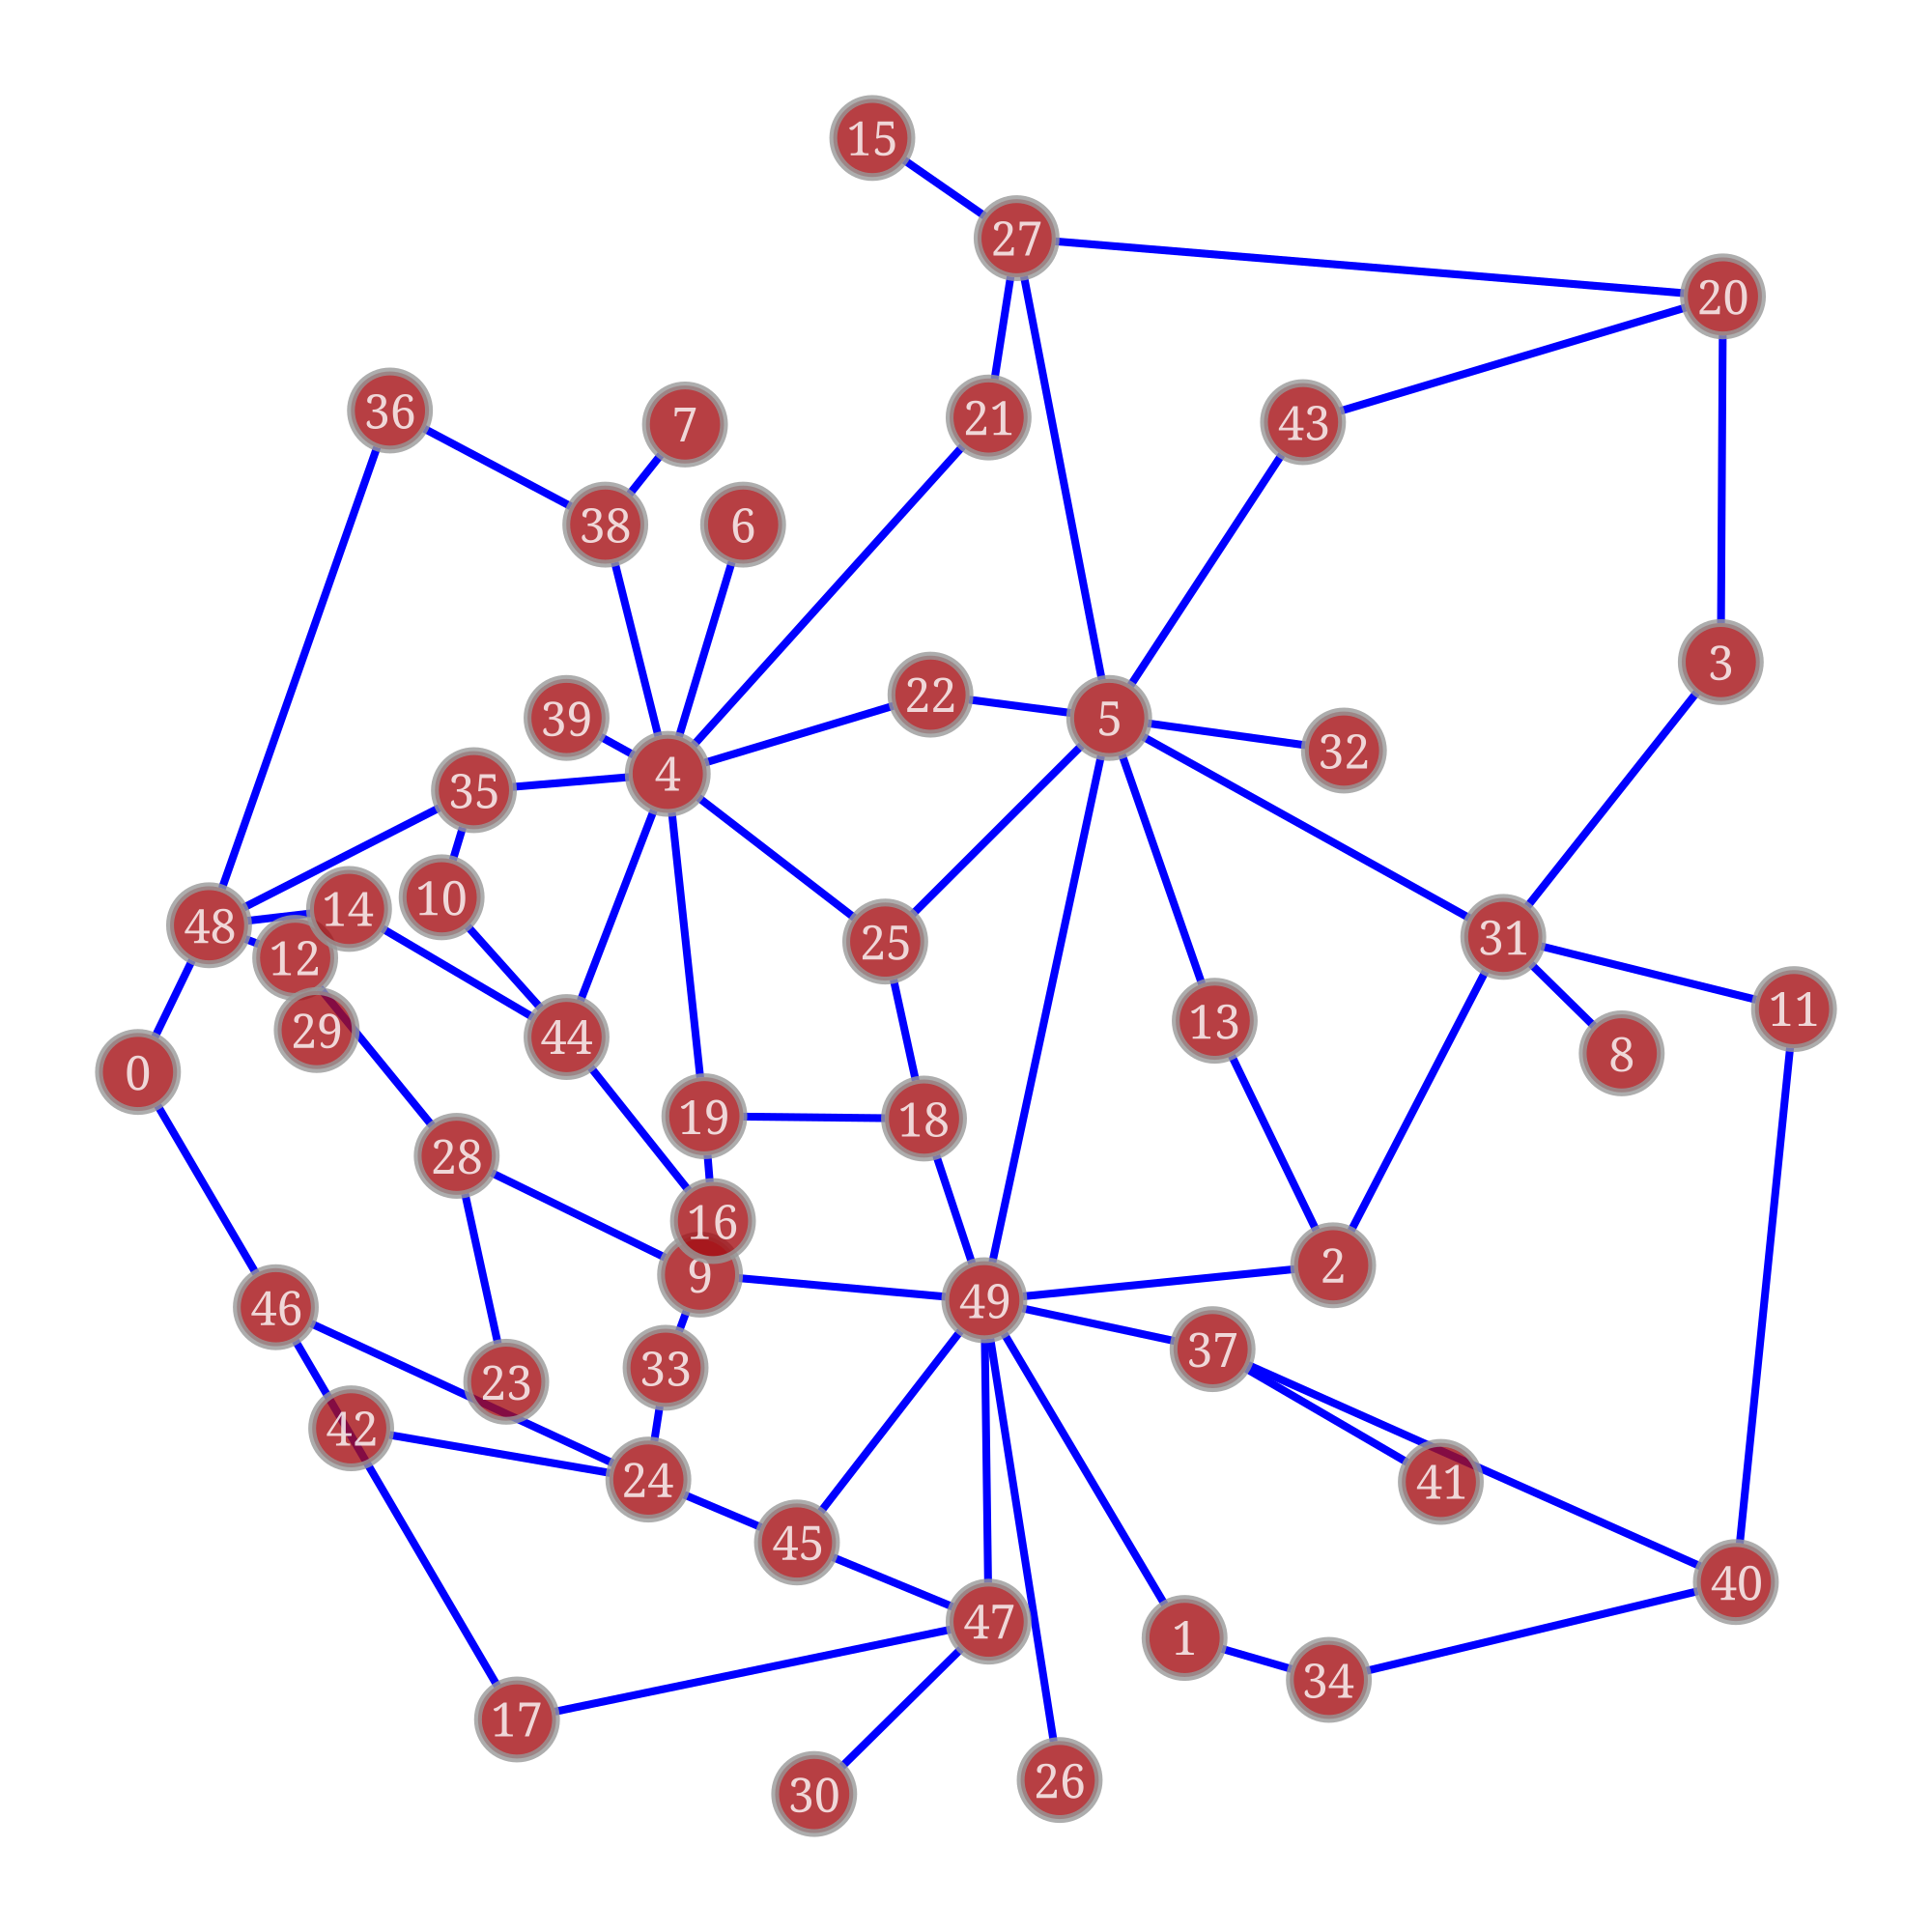

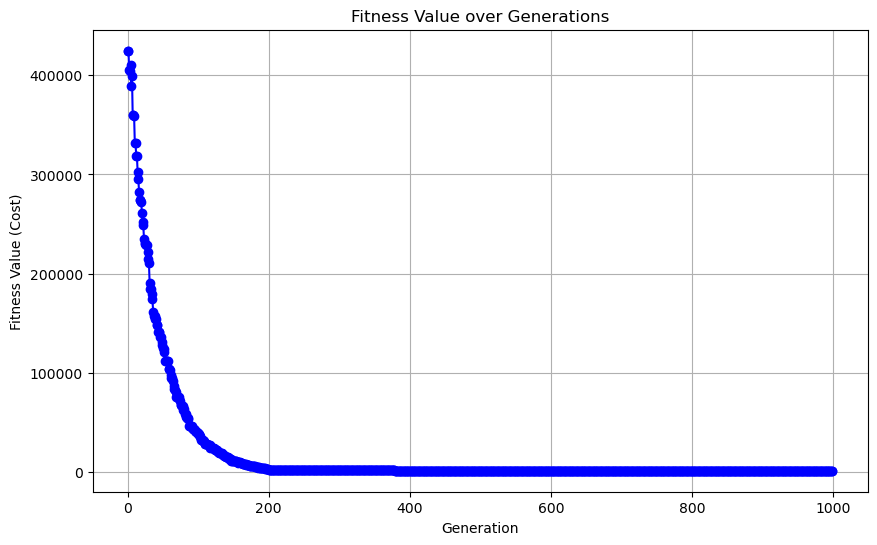

In [15]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 计算两条线段是否相交的函数
def is_intersect(p1, p2, q1, q2):
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69
        return float('inf'),  # 如果边数不为69，适应度设为无穷大

    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])

    # 计算边交叉的惩罚项
    edge_list = [(e.source(), e.target()) for e in graph.edges()]
    cross_count = 0
    for i in range(len(edge_list)):
        for j in range(i + 1, len(edge_list)):
            e1, e2 = edge_list[i], edge_list[j]
            p1, p2 = read_pos[e1[0]], read_pos[e1[1]]
            q1, q2 = read_pos[e2[0]], read_pos[e2[1]]
            if is_intersect(p1, p2, q1, q2):
                cross_count += 1

    # 将交叉的数量添加到总距离中作为惩罚
    total_distance += cross_count * 1000  # 乘以一个大数以增加惩罚力度

    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > 69:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - 69)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < 69:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, 69 - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(1000):
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig("fitness_over_generations.png")
    plt.show()


nodes:  50 links  69
Generation 0: Min Fitness 440556.0281053509
Generation 1: Min Fitness 427235.5870256676
Generation 2: Min Fitness 427204.3256772567
Generation 3: Min Fitness 407923.76083682245
Generation 4: Min Fitness 398738.1930312254
Generation 5: Min Fitness 323400.5954780998
Generation 6: Min Fitness 311469.8058674552
Generation 7: Min Fitness 311469.8058674552
Generation 8: Min Fitness 297280.0440287009
Generation 9: Min Fitness 297280.0440287009
Generation 10: Min Fitness 293483.9330380309
Generation 11: Min Fitness 287109.78893341543
Generation 12: Min Fitness 282422.6000674141
Generation 13: Min Fitness 279279.59369654255
Generation 14: Min Fitness 279279.59369654255
Generation 15: Min Fitness 266445.2569181859
Generation 16: Min Fitness 259516.180726537
Generation 17: Min Fitness 246175.73176232874
Generation 18: Min Fitness 232167.83953766734
Generation 19: Min Fitness 225248.61656302624
Generation 20: Min Fitness 225248.61656302624
Generation 21: Min Fitness 215069.517

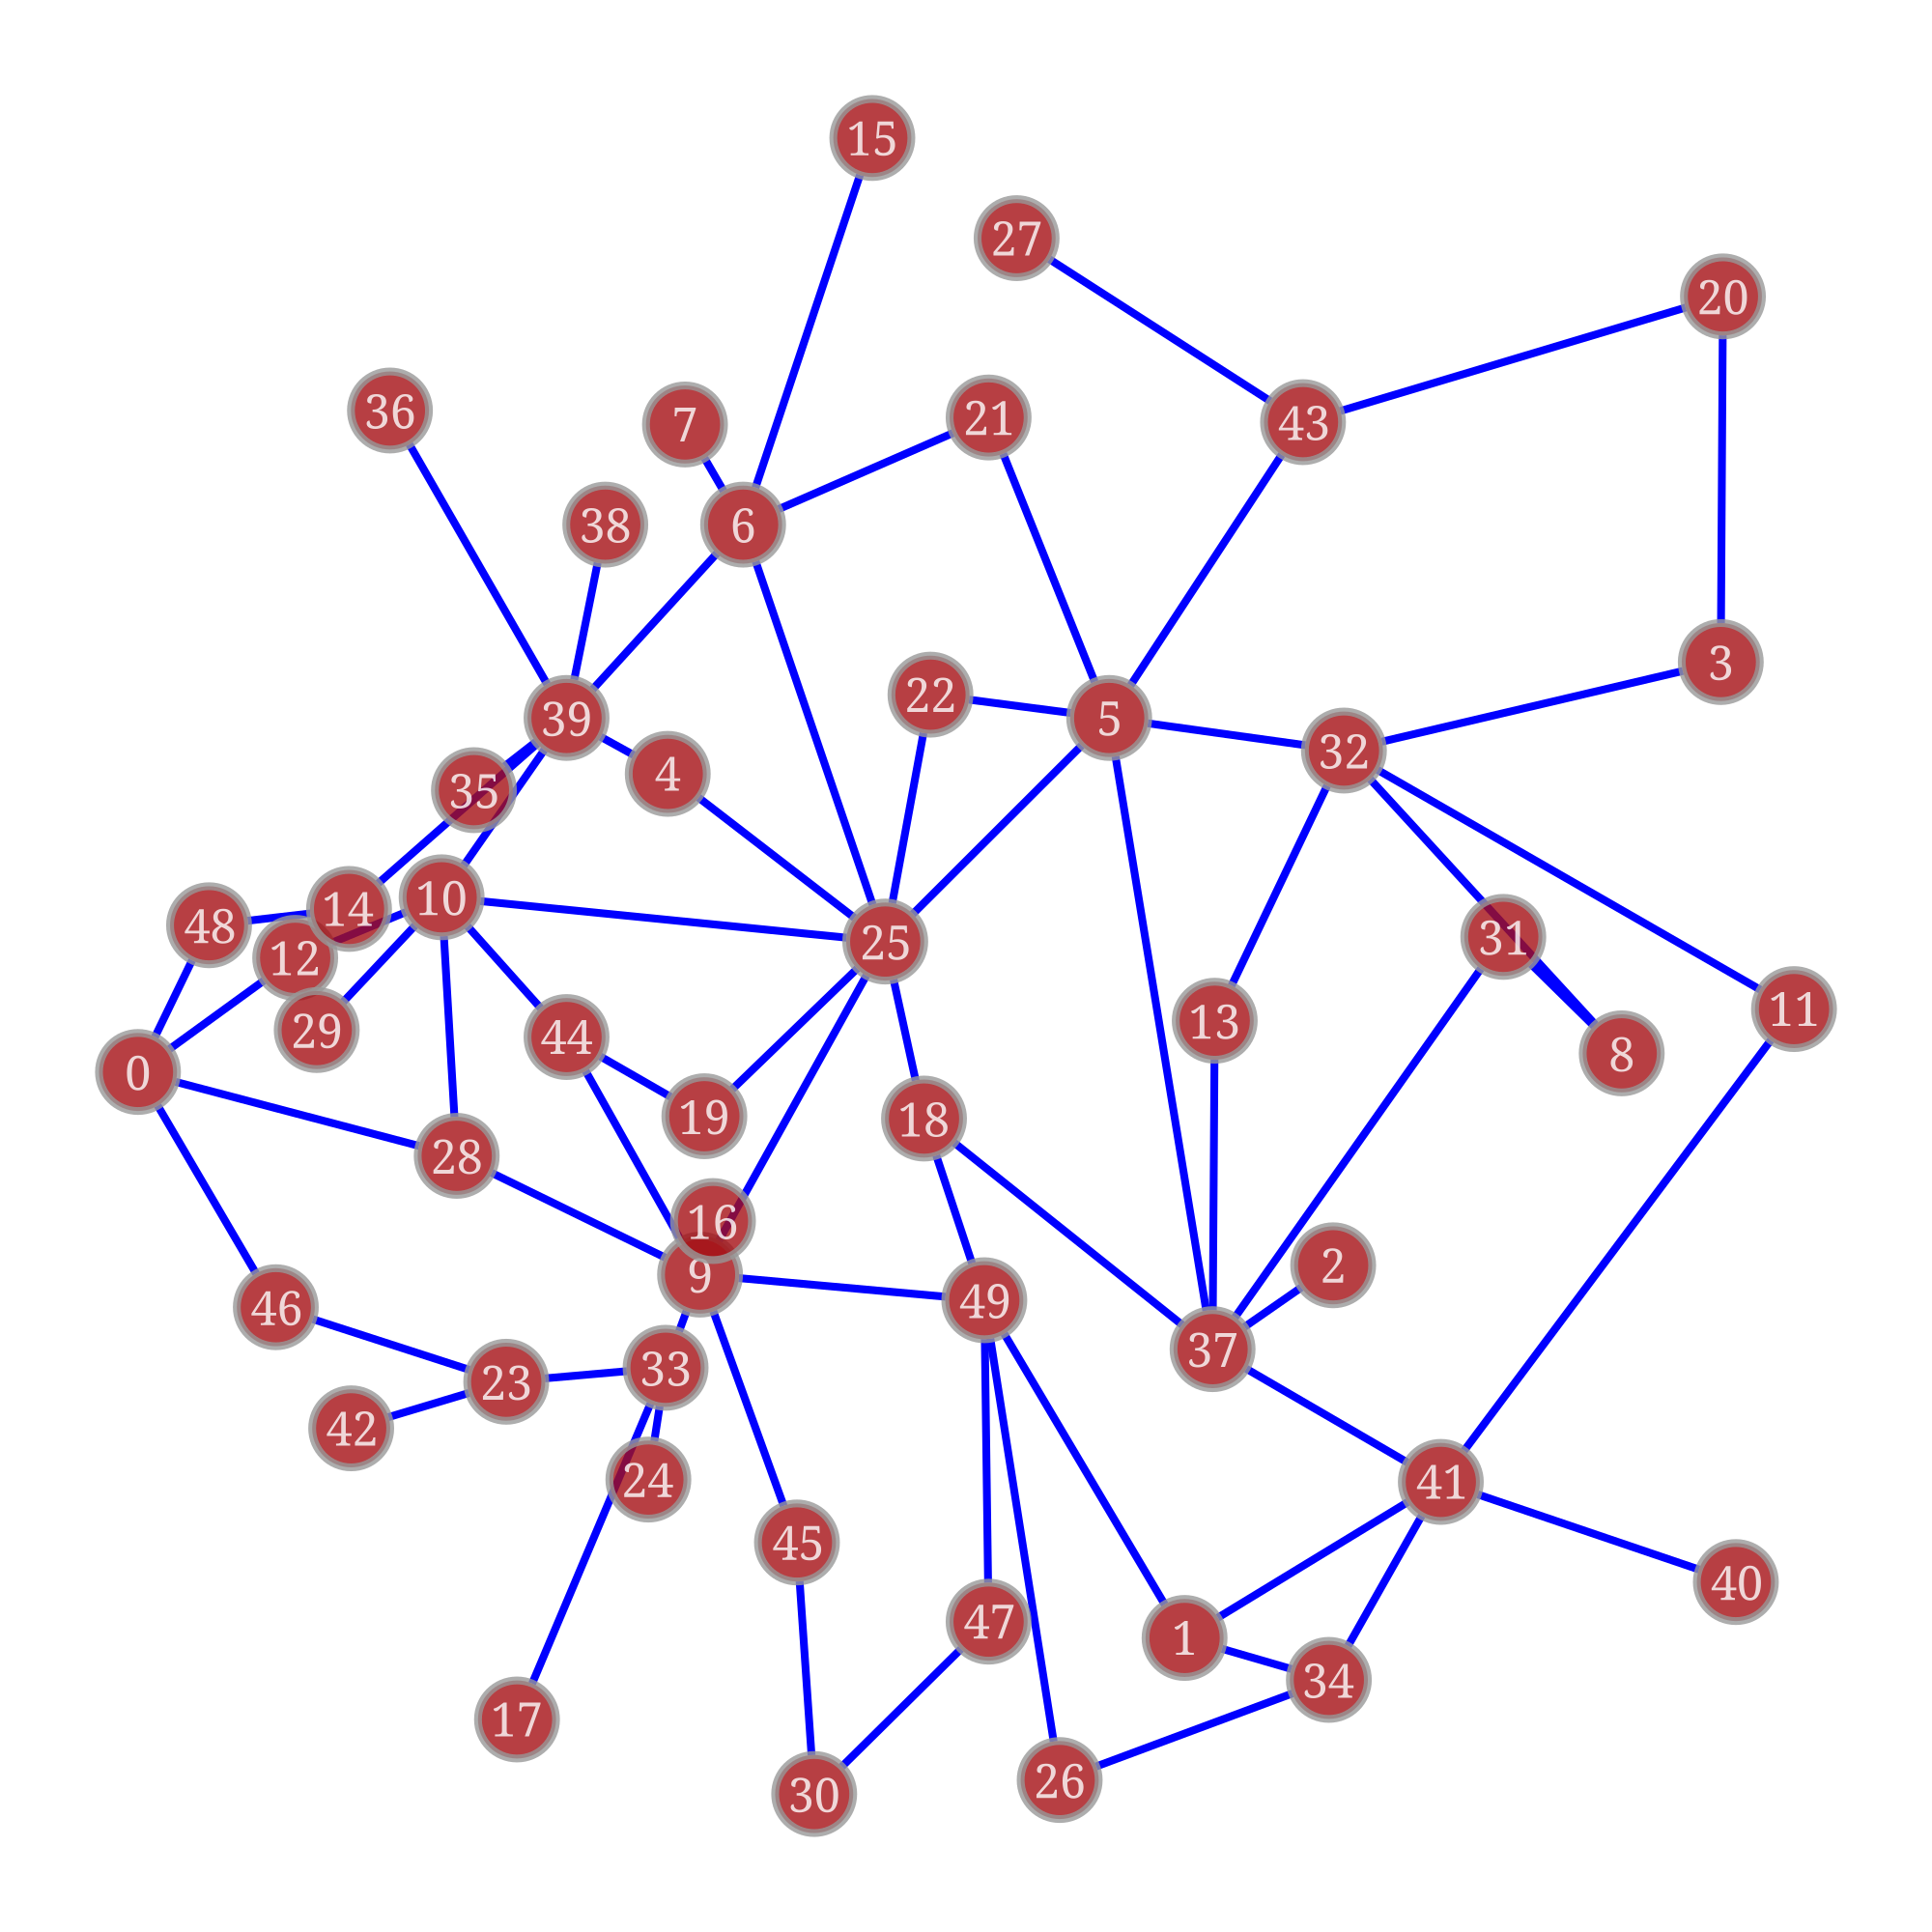

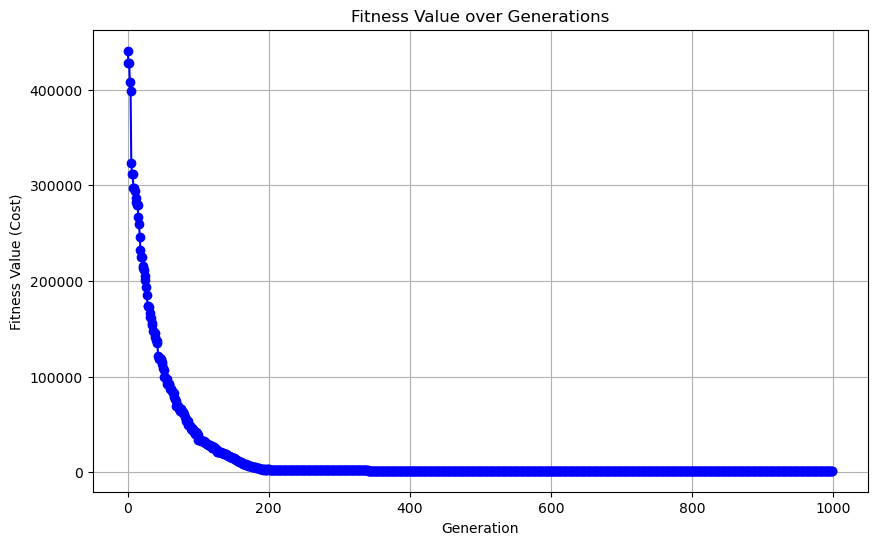

In [17]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from multiprocessing import Pool

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 计算两条线段是否相交的函数
def is_intersect(p1, p2, q1, q2):
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69
        return float('inf'),  # 如果边数不为69，适应度设为无穷大

    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])

    # 计算边交叉的惩罚项
    edge_list = [(e.source(), e.target()) for e in graph.edges()]
    cross_count = 0
    for i in range(len(edge_list)):
        for j in range(i + 1, len(edge_list)):
            e1, e2 = edge_list[i], edge_list[j]
            p1, p2 = read_pos[e1[0]], read_pos[e1[1]]
            q1, q2 = read_pos[e2[0]], read_pos[e2[1]]
            if is_intersect(p1, p2, q1, q2):
                cross_count += 1

    # 将交叉的数量添加到总距离中作为惩罚
    total_distance += cross_count * 1000  # 乘以一个大数以增加惩罚力度

    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > 69:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - 69)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < 69:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, 69 - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pool = Pool()
    toolbox.register("map", pool.map)

    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(1000):
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    pool.close()
    pool.join()

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig("fitness_over_generations.png")
    plt.show()
